In [183]:
import torch
import torch.nn.functional as F
import makemore_layers as ml
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [184]:
words = open("names.txt").read().splitlines()

letters = sorted(list(set(''.join(words)))) #all letters from words

stoi = {l:i+1 for i, l in enumerate(letters)}
stoi['.'] = 0 #add '.' as start or end of the word
itos = {i:l for l, i in stoi.items()}

num_letters = len(stoi)
block_size = 3

In [185]:
def build_dataset(words):
    xs, ys = [], []
    for word in words:
        context = [0] * block_size
        for ch in word+'.':
            xs.append(context)
            nextInd = stoi[ch]
            ys.append(nextInd)
            context = context[1:]+[nextInd]
            
    return torch.tensor(xs), torch.tensor(ys)

random.seed(42)
random.shuffle(words)

ind1 = int(0.8*len(words))
ind2 = int(0.9*len(words))

x_tr, y_tr = build_dataset(words[:ind1])
x_dev, y_dev = build_dataset(words[ind1:ind2])
x_test, y_test = build_dataset(words[ind2:])

In [186]:
#MLP
g = torch.Generator().manual_seed(2147483647)

num_emb = 10
num_hidden = 100
num_h = num_emb*block_size

C = torch.randn((num_letters, num_emb), generator=g)
layers = [
    ml.Linear(num_h,      num_hidden,  g, bias=False), ml.BatchNorm1d(num_hidden), ml.Tanh(),
    ml.Linear(num_hidden, num_hidden,  g, bias=False), ml.BatchNorm1d(num_hidden), ml.Tanh(),
    ml.Linear(num_hidden, num_hidden,  g, bias=False), ml.BatchNorm1d(num_hidden), ml.Tanh(),
    ml.Linear(num_hidden, num_hidden,  g, bias=False), ml.BatchNorm1d(num_hidden), ml.Tanh(),
    ml.Linear(num_hidden, num_hidden,  g, bias=False), ml.BatchNorm1d(num_hidden), ml.Tanh(),
    ml.Linear(num_hidden, num_letters, g, bias=False), ml.BatchNorm1d(num_letters), # ?
]

with torch.no_grad():
    # normilize last layer
    layers[-1].gamma *= 0.1 # ?
    # normilize weights for non-linear tanh function
    for layer in layers:
        if isinstance(layer, ml.Linear):
            layer.weights *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

In [187]:
ud = []
# losses = []

def training(epoch=200, batch_size=30, learning_rate=0.01):
    for i in range(epoch):
        # minibatch construct
        inds = torch.randint(0, x_tr.shape[0], (batch_size,))
        x_b, y_b = x_tr[inds], y_tr[inds]
        
        # forward pass
        emb = C[x_b] # shape: batch_size, block_size, num_emb
        x = emb.view(emb.shape[0], -1) # shape: (batch_size, num_h)
        for layer in layers:
            x = layer(x)
            
        loss = F.cross_entropy(x, y_b)
        if i % 1000 == 0: print(loss.item())

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # for histogram
    
        for p in parameters:
            p.grad = None # set to zero the gradient
            
        loss.backward()
        
        # update
        for p in parameters:
            p.data -= learning_rate * p.grad
            
        # track
        # losses.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((learning_rate*p.grad).std() / p.data.std()).log10().item() for p in parameters]) # ?
        
    print(loss.item())

for layer in layers:
    layer.training = True
     
training(epoch=200000, batch_size=50, learning_rate=0.1)

3.291900873184204
2.2892446517944336
2.282768487930298
2.103482961654663
1.9188592433929443
2.646646022796631
2.554182767868042
2.355268955230713
2.2677676677703857
2.172430992126465
2.2330679893493652
2.0414273738861084
2.441495895385742
2.168905258178711
1.8824609518051147
2.024899482727051
2.1511666774749756
2.37226939201355
2.0237410068511963
1.8448240756988525
2.130031108856201
2.4008660316467285
1.9116955995559692
2.4248878955841064
2.0298655033111572
2.0257668495178223
2.173205614089966
2.217268705368042
2.1286046504974365
2.2693488597869873
2.4932351112365723
2.462327003479004
1.9654829502105713
2.2698192596435547
1.9537299871444702
1.8655253648757935
1.9019253253936768
2.4837615489959717
2.07265567779541
1.9165596961975098
1.9887405633926392
2.2775025367736816
2.2959868907928467
2.1223337650299072
2.3311548233032227
2.0100643634796143
2.1858201026916504
2.075507879257202
2.1603286266326904
2.0834715366363525
2.2834999561309814
1.9977954626083374
1.9327584505081177
2.2757923603

layer 2 (Tanh): mean -0.00, std 0.72, saturated: 17.72%
layer 5 (Tanh): mean -0.01, std 0.76, saturated: 20.52%
layer 8 (Tanh): mean -0.01, std 0.78, saturated: 23.26%
layer 11 (Tanh): mean -0.01, std 0.79, saturated: 24.42%
layer 14 (Tanh): mean -0.02, std 0.81, saturated: 28.36%


Text(0.5, 1.0, 'Activation distribution')

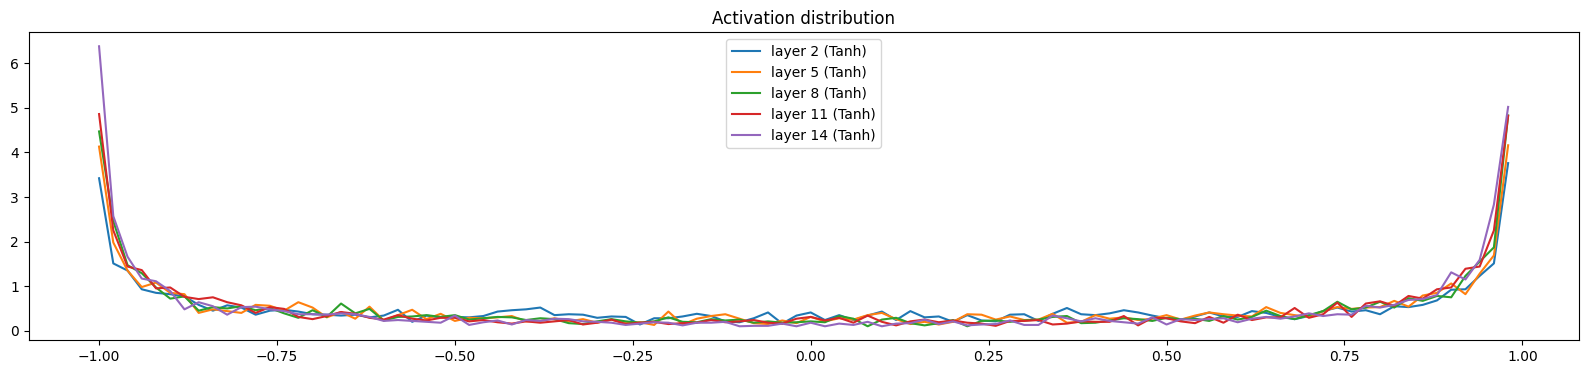

In [188]:
# visualize histogram of the activations
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, ml.Tanh):
    out = layer.out
    print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, out.mean(), out.std(), (out.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(out, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
    
plt.legend(legends)
plt.title('Activation distribution')

layer 2 (Tanh): mean -0.000000, std 3.094779e-03
layer 5 (Tanh): mean -0.000000, std 2.759818e-03
layer 8 (Tanh): mean -0.000000, std 2.593060e-03
layer 11 (Tanh): mean -0.000000, std 2.513000e-03
layer 14 (Tanh): mean -0.000000, std 2.653621e-03


Text(0.5, 1.0, 'Tanh gradient distribution')

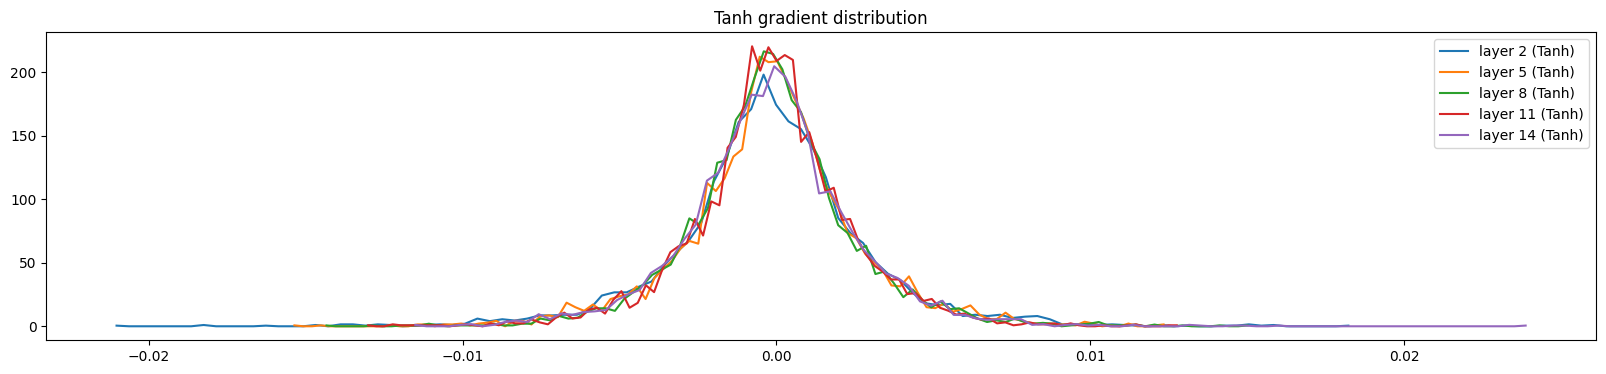

In [189]:
# visualize histogram of Tanh gradient
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, ml.Tanh):
    grad = layer.out.grad
    print('layer %d (%s): mean %+f, std %e' % (i, layer.__class__.__name__, grad.mean(), grad.std()))
    hy, hx = torch.histogram(grad, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
    
plt.legend(legends)
plt.title('Tanh gradient distribution')

weights   (27, 10) | mean -0.000000 | std 1.313380e-02 | grad:data ratio 1.132687e-02
weights  (30, 100) | mean +0.000035 | std 7.683038e-03 | grad:data ratio 1.655877e-02
weights (100, 100) | mean +0.000094 | std 4.975047e-03 | grad:data ratio 1.725279e-02
weights (100, 100) | mean -0.000010 | std 4.823594e-03 | grad:data ratio 1.697667e-02
weights (100, 100) | mean +0.000019 | std 4.637935e-03 | grad:data ratio 1.677358e-02
weights (100, 100) | mean +0.000029 | std 4.356772e-03 | grad:data ratio 1.648520e-02
weights  (100, 27) | mean +0.000056 | std 7.061803e-03 | grad:data ratio 1.799013e-02


Text(0.5, 1.0, 'Weights gradient distribution')

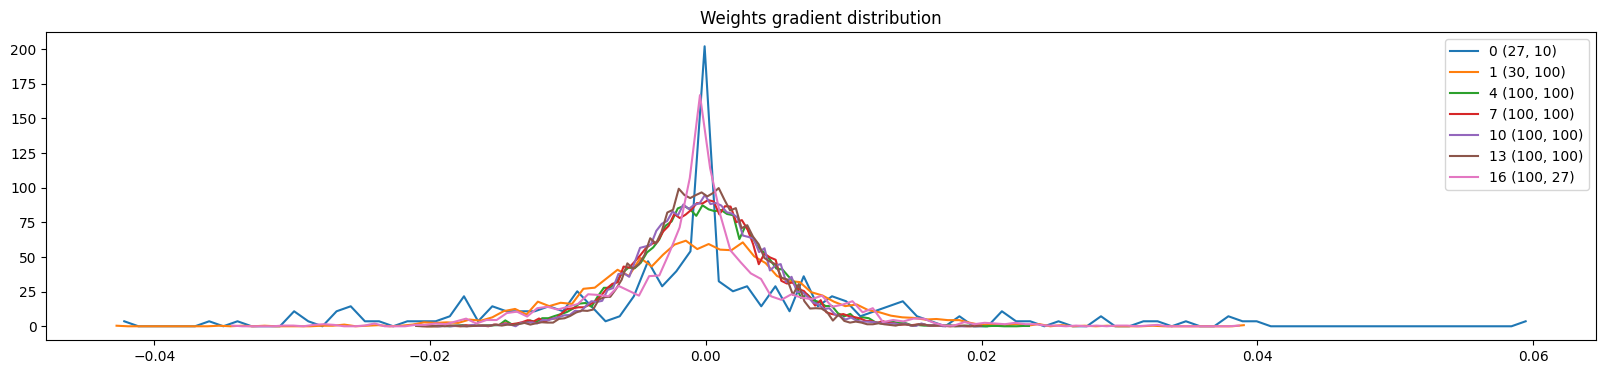

In [190]:
# visualize histogram of weights gradient distribution
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
  if p.ndim == 2:
    grad = p.grad
    print('weights %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), grad.mean(), grad.std(), grad.std() / p.std()))
    hy, hx = torch.histogram(grad, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
    
plt.legend(legends)
plt.title('Weights gradient distribution')

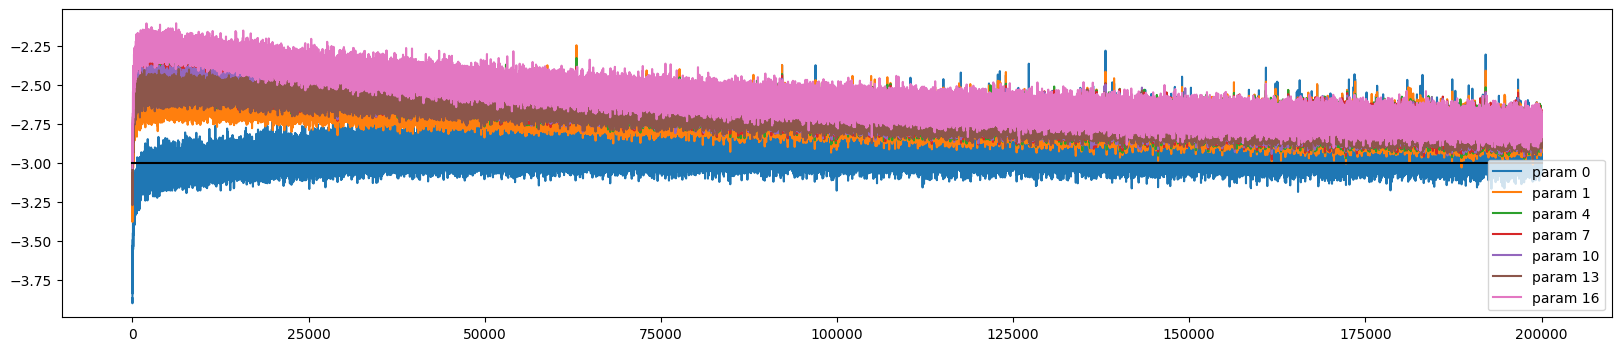

In [191]:
# learning rate
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
    
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot

plt.legend(legends)

In [192]:
@torch.no_grad()
def get_loss(data):
    x, y = {
        'train': (x_tr, y_tr),
        'dev': (x_dev, y_dev),
        'test': (x_test, y_test)
    }[data]
    
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, y)
    print(data, loss.item())

for layer in layers:
    layer.training = False
    
get_loss('train')
get_loss('dev')

train 1.9973515272140503
dev 2.0890159606933594


In [193]:
def generateName(g):
    result = ''
    ind = 0
    context = [0] * block_size 
    
    while True:
        # emb = C[torch.tensor([context])]
        emb = C[context] # shape: (block_size,num_emb)
        x = emb.view(1, -1)
        for layer in layers:
            x = layer(x)
            
        probs = F.softmax(x, dim=1)

        ind = torch.multinomial(probs, num_samples=1, generator=g).item()
        if ind == 0: break
        result += itos[ind]
        context = context[1:]+[ind]

    return result

g = torch.Generator().manual_seed(21474836327)

for layer in layers:
    layer.training = False
        
for _ in range(10):
    print(generateName(g))

novanardum
myrohanna
marett
gramte
destenah
wella
tamar
arliah
creselen
jamarique
